In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20.0, 10.0]
plt.rcParams.update({'font.size': 22,})
import seaborn as sns
from google.colab import drive

import os
import time
import shutil
import numpy as np 
np.random.seed(22)
import random
random.seed(33)
import pandas as pd 
from tqdm import tqdm
import gc
import math
import string
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import plotly.express as pe
from wordcloud import WordCloud, STOPWORDS 

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
songs_df = pd.read_csv("/content/drive/MyDrive/W266 NLP/Project/Music/lyrics.csv")
del songs_df["index"]
songs_df.head(10)

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
5,all-i-could-do-was-cry,2009,beyonce-knowles,Pop,I heard\nChurch bells ringing\nI heard\nA choi...
6,once-in-a-lifetime,2009,beyonce-knowles,Pop,This is just another day that I would spend\nW...
7,waiting,2009,beyonce-knowles,Pop,"Waiting, waiting, waiting, waiting\nWaiting, w..."
8,slow-love,2009,beyonce-knowles,Pop,[Verse 1:]\nI read all of the magazines\nwhile...
9,why-don-t-you-love-me,2009,beyonce-knowles,Pop,"N-n-now, honey\nYou better sit down and look a..."


In [ ]:
songs_df.shape

(362237, 5)

In [ ]:
print('Number of songs with empty lyrics is {0:.0f}'.format(np.sum(songs_df['year'].isnull())))

Number of songs with empty lyrics is 0


## EDA and Text Processing

In [ ]:
print('Number of songs with empty lyrics is {0:.0f}'.format(np.sum(songs_df['lyrics'].isnull())))
print('Number of songs with empty genre is {0:.0f}'.format(np.sum(songs_df['genre'].isnull())))

Number of songs with empty lyrics is 95680
Number of songs with empty genre is 0


In [ ]:
# remove songs with empty lyrics
songs_df = songs_df[songs_df['lyrics'].notnull()]

In [ ]:
print('Average word length of lyrics is {0:.0f}'.format(np.nanmean(songs_df['lyrics'].apply(lambda x: len(x.split())))))
print('Max word length of lyrics is {0:.0f}'.format(np.max(songs_df['lyrics'].apply(lambda x: len(x.split())))))
print('Average character length of lyrics is {0:.0f}'.format(np.mean(songs_df['lyrics'].apply(lambda x: len(x)))))
print('Count of unique words in lyrics is {:,}'.format(np.sum(songs_df["lyrics"].apply(lambda x: len(str(x).split())))))

stop_words = set(stopwords.words('english')) #from nltk
print('Count of stop words in lyrics is {:,}'.format(np.sum(songs_df["lyrics"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words])))))
print('Count of punctuations in lyrics is {:,}'.format(np.sum(songs_df["lyrics"].apply(lambda x: len([c for c in str(x) if c in string.punctuation])))))

Average word length of lyrics is 227
Max word length of lyrics is 8195
Average character length of lyrics is 1146
Count of unique words in lyrics is 60,544,825
Count of stop words in lyrics is 26,169,851
Count of punctuations in lyrics is 9,343,649


## Distribution Plots

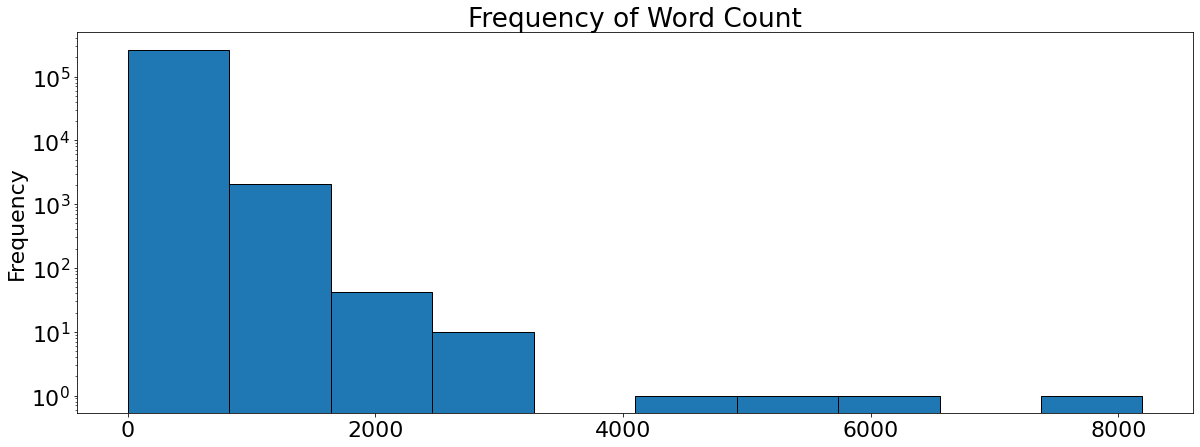

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

songs_df['lyrics'].apply(lambda x: len(x.split())).plot(kind='hist', ec='black');
plt.yscale('log');
plt.title('Frequency of Word Count')
plt.show()

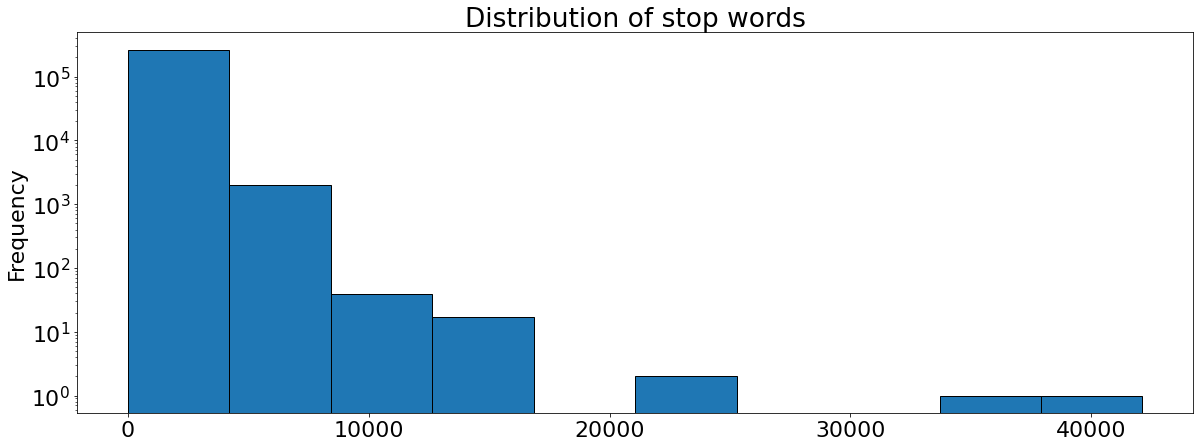

In [ ]:
songs_df['lyrics'].apply(lambda x : np.mean([len(x) for c in str(x).split()])).plot(kind='hist', ec='black');
plt.yscale('log');
plt.title('Distribution of stop words')
plt.show()

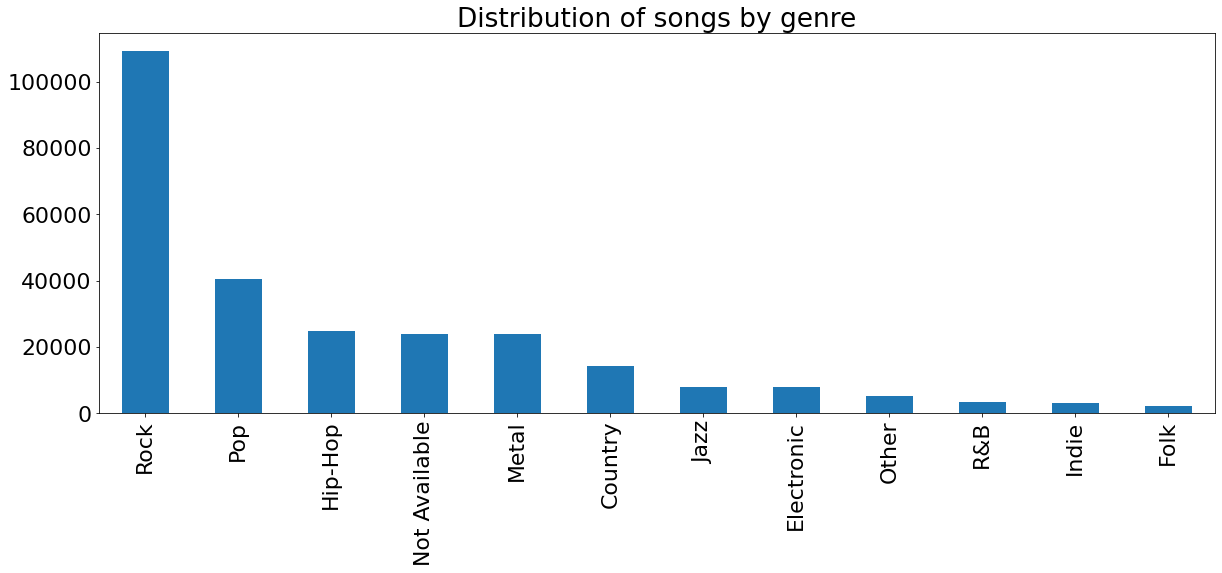

In [ ]:
# Rock music dominates the dataset; highly imbalanced
songs_df['genre'].value_counts().plot(kind='bar');
#plt.yscale('log');
plt.title('Distribution of songs by genre')
plt.show()

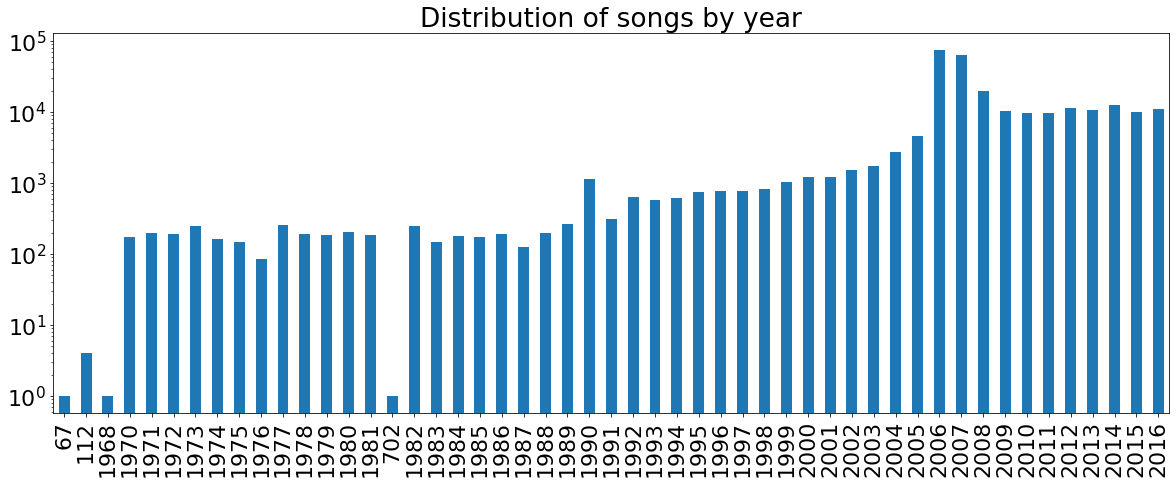

16860

In [ ]:
songs_df['year'].value_counts(sort=False).plot(kind='bar');
plt.yscale('log');
plt.title('Distribution of songs by year')
plt.show()

gc.collect()

# Text Processing

In [ ]:
def lyric_preprocessing():
  cleaned = songs_df.copy()
  # lowercase words
  cleaned['lyrics'] = cleaned['lyrics'].apply(lambda x: x.lower())

  # remove punctuation
  cleaned['lyrics'] = cleaned['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()]", ' ')

  # remove'\n' in lyrics
  cleaned['lyrics'] = cleaned['lyrics'].apply(lambda x: x.replace('\n', ' '))

  # remove song-related identifiers like [Chorus] or [Verse]
  cleaned['lyrics'] = cleaned['lyrics'].str.replace("\[(.*?)\]", ' ')
  cleaned['lyrics'] = cleaned['lyrics'].str.replace("' | '", ' ')
  cleaned['lyrics'] = cleaned['lyrics'].str.replace('x[0-9]+', ' ')

  # remove all songs without lyrics (e.g. instrumental pieces)
  cleaned = cleaned[cleaned['lyrics'].str.strip().str.lower() != 'instrumental']

  # remove any songs with corrupted/non-ASCII characters, unavailable lyrics
  cleaned = cleaned[~cleaned['lyrics'].str.contains(r'[^\x00-\x7F]+')]
  cleaned = cleaned[cleaned['lyrics'].str.strip() != '']
  cleaned = cleaned[cleaned['genre'].str.lower() != 'not available']

  return cleaned

In [ ]:
def documentNgrams(documents, size):
    ngrams_all = []
    for document in documents:
        tokens = document.split()
        if len(tokens) <= size:
            continue
        else:
            output = list(ngrams(tokens, size))
        for ngram in output:
            ngrams_all.append(" ".join(ngram))
    cnt_ngram = Counter()
    for word in ngrams_all:
        cnt_ngram[word] += 1
    df = pd.DataFrame.from_dict(cnt_ngram, orient='index').reset_index()
    df = df.rename(columns={'index':'words', 0:'count'})
    df = df.sort_values(by='count', ascending=False)
    df = df.head(15)
    df = df.sort_values(by='count')
    return(df)

In [ ]:
def plotNgrams(documents):
    # unigrams = documentNgrams(documents, 1)
    # bigrams = documentNgrams(documents, 2)
    trigrams = documentNgrams(documents, 3)
    fourgram = documentNgrams(documents, 4)
    fivegrams = documentNgrams(documents, 5)

    plt.rcParams['figure.figsize'] = [25.0, 8.0]
    plt.rcParams.update({'font.size': 14,})
    
    # Set plot figure size
    fig = plt.figure(figsize = (30, 10))
    plt.subplots_adjust(wspace=.5)

    ax = fig.add_subplot(131)
    ax.barh(np.arange(len(trigrams['words'])), trigrams['count'], align='center', alpha=.5)
    ax.set_title('Trigrams')
    plt.yticks(np.arange(len(trigrams['words'])), trigrams['words'])
    plt.xlabel('Count')

    ax2 = fig.add_subplot(132)
    ax2.barh(np.arange(len(fourgram['words'])), fourgram['count'], align='center', alpha=.5)
    ax2.set_title('Four grams')
    plt.yticks(np.arange(len(fourgram['words'])), fourgram['words'])
    plt.xlabel('Count')

    ax3 = fig.add_subplot(133)
    ax3.barh(np.arange(len(fivegrams['words'])), fivegrams['count'], align='center', alpha=.5)
    ax3.set_title('Five grams')
    plt.yticks(np.arange(len(fivegrams['words'])), fivegrams['words'])
    plt.xlabel('Count')

    plt.show()

In [ ]:
cleaned = lyric_preprocessing()
cleaned.head()

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing you know i'm gonna cut...
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem ...
2,honesty,2009,beyonce-knowles,Pop,if you search for tenderness it isn't hard to ...
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i if i wrote a book abo...
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party it's po...


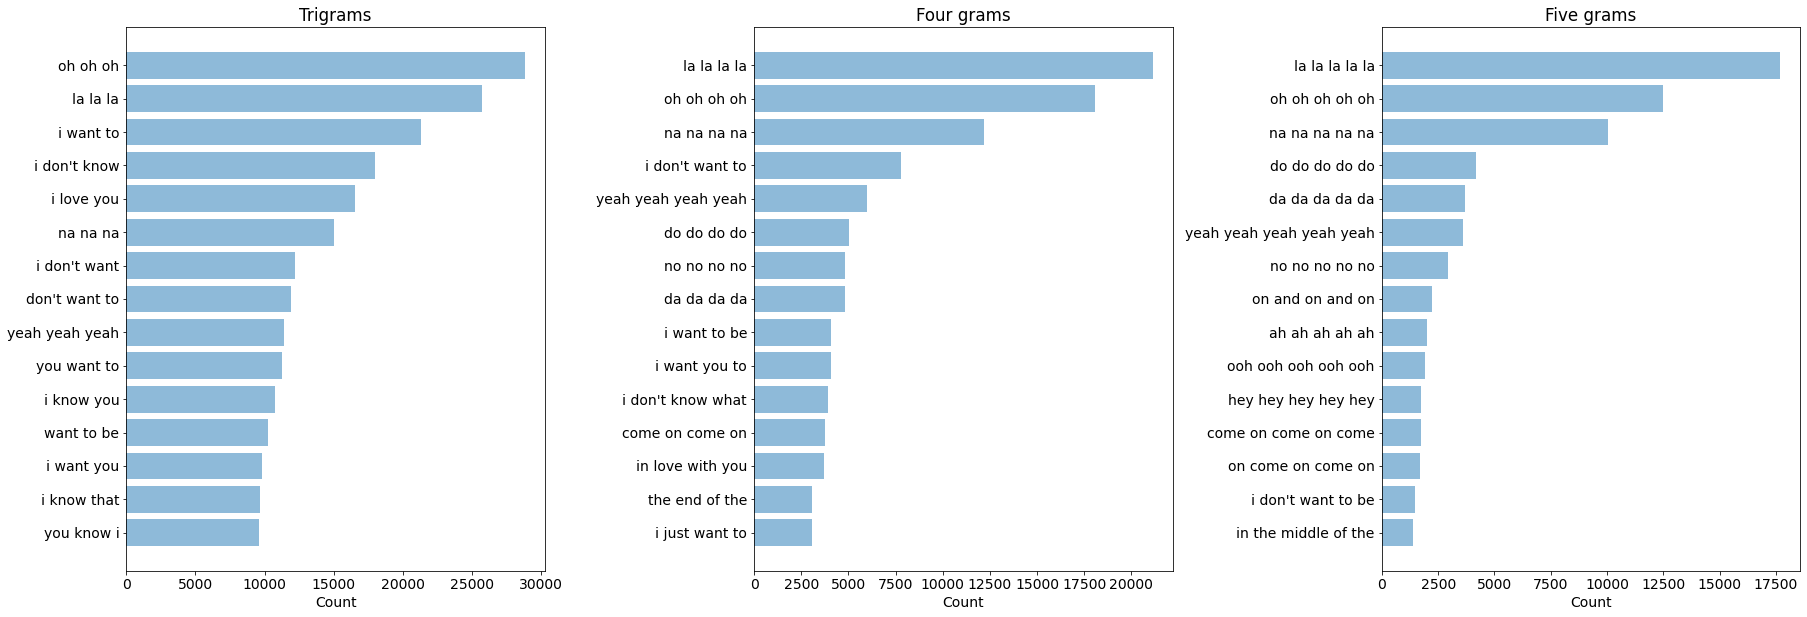

11077

In [ ]:
plotNgrams(cleaned['lyrics'])

gc.collect()

In [ ]:
from nltk.tokenize import word_tokenize
length = []
for sent in cleaned.lyrics:
    lent = len(word_tokenize(sent))
    length.append(lent)

gc.collect()

53

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



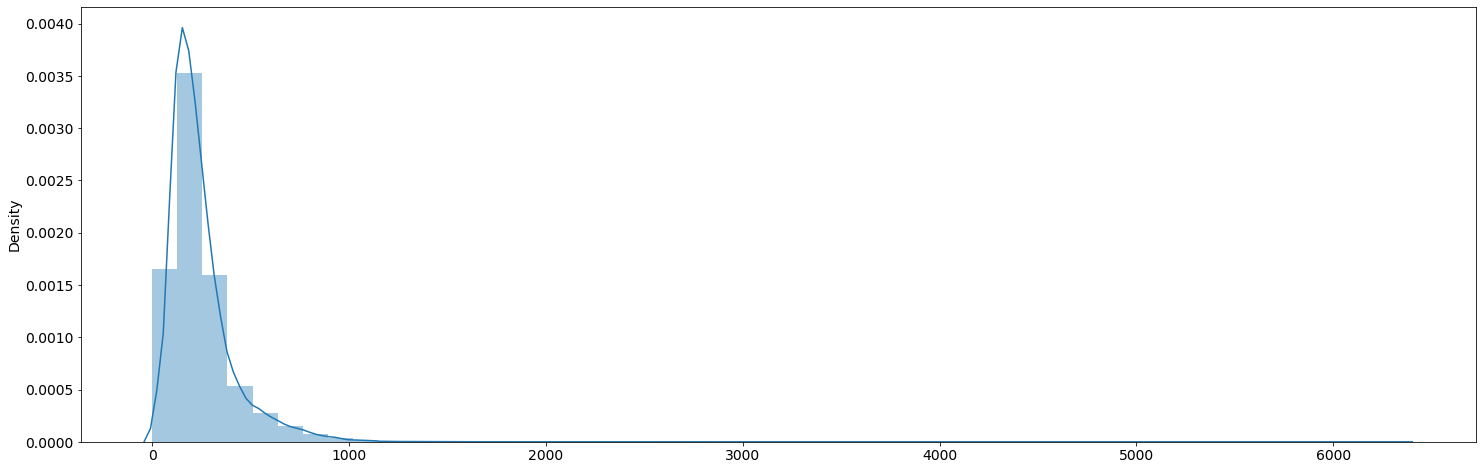

In [ ]:
sns.distplot(length)

In [ ]:
# set max_seq_length to 300, since the average number of tokens per song is 244
print('Average number of tokens per song is {0:.0f}'.format(np.mean(length)))

Average number of tokens per song is 244


In [ ]:
# add word count per song
cleaned['word_count'] = cleaned['lyrics'].str.split().str.len()
print(cleaned['word_count'].describe())
cleaned.head()

count    227436.000000
mean        231.289435
std         156.905544
min           1.000000
25%         132.000000
50%         193.000000
75%         281.000000
max        6210.000000
Name: word_count, dtype: float64


,song,year,artist,genre,lyrics,word_count
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing you know i'm gonna cut...,433
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem ...,258
2,honesty,2009,beyonce-knowles,Pop,if you search for tenderness it isn't hard to ...,170
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i if i wrote a book abo...,514
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party it's po...,312


In [ ]:
# summary of samples per genre
cleaned.genre.value_counts()

Rock          104128
Pop            36439
Hip-Hop        23215
Metal          22417
Country        14182
Jazz            7520
Electronic      7230
Other           3989
R&B             3354
Indie           2970
Folk            1992
Name: genre, dtype: int64

In [ ]:
# unique artists in dataset
cleaned.artist.nunique()

11117

In [ ]:
# quantile word count
cleaned['word_count'].quantile(.01)

21.0

In [ ]:
# quantile word count
cleaned['word_count'].quantile(.99)

800.0

In [ ]:
# retain songs with lyrics >= 20 and <= 800 word count 
cleaned_df = cleaned[cleaned['word_count'] >= 20]
cleaned_df = cleaned_df[cleaned_df['word_count'] <= 800]
cleaned_df.head()

,song,year,artist,genre,lyrics,word_count
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing you know i'm gonna cut...,433
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem ...,258
2,honesty,2009,beyonce-knowles,Pop,if you search for tenderness it isn't hard to ...,170
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i if i wrote a book abo...,514
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party it's po...,312


In [ ]:
# remove songs that did not fit the word count criteria
cleaned_df.shape

(223040, 6)

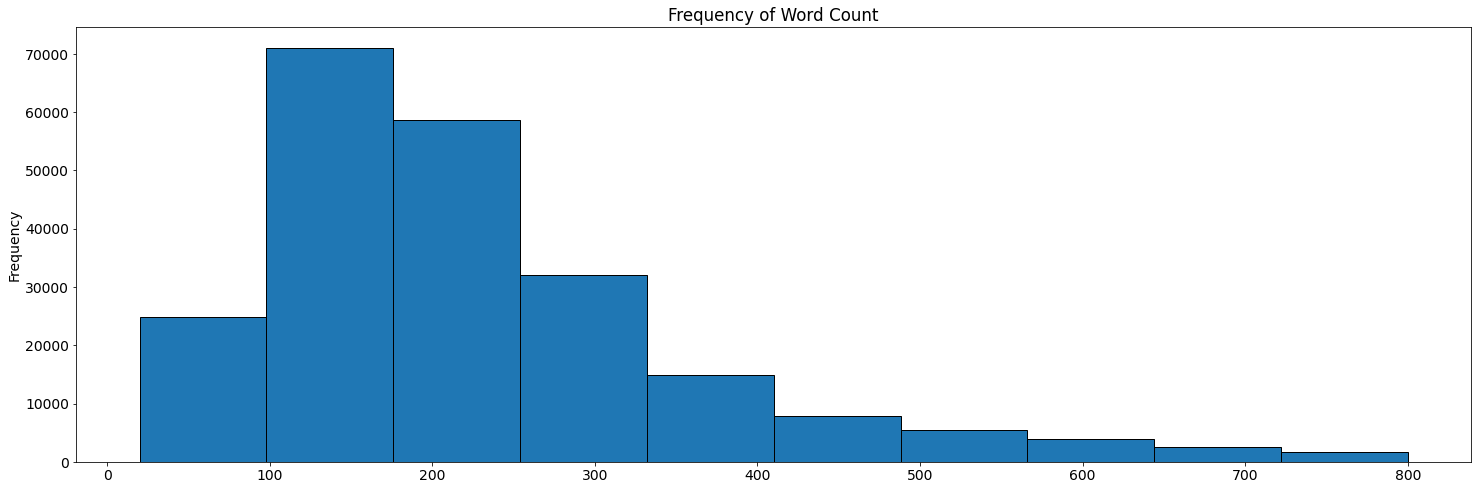

In [ ]:
# plot average word count distribution
cleaned_df['lyrics'].apply(lambda x: len(x.split())).plot(kind='hist', ec='black');
# plt.yscale('log');
plt.title('Frequency of Word Count')
plt.show()

In [ ]:
cleaned_df.drop(["word_count"],axis=1,inplace=True)
cleaned_df.head()

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing you know i'm gonna cut...
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem ...
2,honesty,2009,beyonce-knowles,Pop,if you search for tenderness it isn't hard to ...
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i if i wrote a book abo...
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party it's po...


In [ ]:
# save cleaned file to csv for posterity
cleaned_df.to_csv('cleaned_lyrics_final3.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
